# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

# Todo List
- Add several dense layers after convolutional layers
- Play with learning rate and batch size

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# Import Data

In [3]:
import os
dataset_dir = 'DataSet/'

In [4]:
count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith(".pkl"): 
        df = pd.read_pickle(os.path.join(dataset_dir, filename))
        
        if count == 0:
            raw_df = df
        else:
            raw_df = raw_df.append(df, ignore_index=True)
            
        print('File: {}, DataSet Length: {}'.format(os.path.join(dataset_dir, filename), len(df)))
        count += 1
    else:
        continue
print('Total Length: {}'.format(len(raw_df)))

File: DataSet/2018-07-13_18-39-56_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-43-51_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-46-04_1.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-47-58_2.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-49-54_3.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-52-16_4.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-54-29_5.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-56-38_6.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-58-30_7.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-00-21_8.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-02-36_9.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-04-42_10.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-06-38_11.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-08-49_12.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-10-48_13.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-12-43_14.pkl, DataSet Length: 500
File: DataSet/2018-

In [5]:
# # Read saved list of data from object into a dataframe
# raw_df = pd.read_pickle('DataSet/data_07-10-18.pkl')
# print(len(raw_df))
# raw_df.head()

In [6]:
data_width = len(raw_df['data'][0])

# Data Preprocessing

#### Filter out key counts less than threshold value

In [7]:
import collections
import matplotlib.pyplot as plt
key_count = collections.Counter(raw_df['key'])

In [8]:
width = 0.5 # Bar width
figsize = (15, 4)

def plot_key_hist(most_common):
    if len(most_common) > 30:
        most_common = most_common[:30]
        
    hist_labels, hist_values = zip(*most_common) # Show only a subset of all keys
    indexes = np.arange(len(hist_labels))
    plt.figure(figsize=figsize)
    plt.bar(indexes, hist_values, width)
    plt.xticks(indexes + width * 0.5, hist_labels, rotation='vertical')
    plt.show()

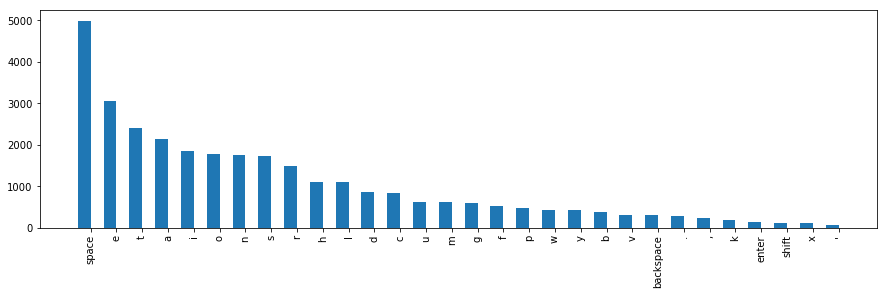

In [9]:
plot_key_hist(key_count.most_common())

In [10]:
key_count.most_common

<bound method Counter.most_common of Counter({'space': 4990, 'e': 3070, 't': 2414, 'a': 2135, 'i': 1858, 'o': 1774, 'n': 1766, 's': 1738, 'r': 1490, 'h': 1109, 'l': 1102, 'd': 877, 'c': 837, 'u': 629, 'm': 623, 'g': 591, 'f': 517, 'p': 479, 'w': 431, 'y': 429, 'b': 392, 'v': 311, 'backspace': 309, '.': 283, ',': 246, 'k': 188, 'enter': 148, 'shift': 120, 'x': 107, "'": 76, '0': 69, 'z': 67, 'ctrl_l': 60, '-': 54, '1': 45, '2': 43, 'q': 42, 'delete': 38, 'down': 38, '9': 35, 'j': 26, '3': 24, '5': 20, 'esc': 17, '/': 17, 'left': 16, ';': 16, '7': 15, '8': 14, '6': 14, '4': 14, 'up': 10, 'right': 8, 'tab': 4, '=': 4, '`': 1})>

In [11]:
# Maximize DataSet Size By Finding Optimal Threshold
max_data_size = 0
max_class_cnt = 0
threshold_max = 0
for _, v in key_count.most_common():
    threshold = v - 1
    min_thresh_cnts = [count for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]
    class_cnt = len(min_thresh_cnts)
    data_size = min(min_thresh_cnts)*len(min_thresh_cnts)
    if data_size > max_data_size:
        max_data_size = data_size
        max_class_cnt = class_cnt
        threshold_max = threshold
print('Max Data Size: {}, Class Count: {}, Threshold: {}'.format(max_data_size, max_class_cnt, threshold_max))

Max Data Size: 13904, Class Count: 8, Threshold: 1737


In [12]:
# Get list of keys with counts greater than threshold
threshold = threshold_max
min_thresh_keys = [key for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]

In [13]:
min_thresh_df = raw_df[raw_df['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold

In [14]:
def trim_max_thresh(grouped_class):
    return grouped_class.sample(threshold)

In [15]:
# Keep same number of samples in each class by throwing away everything past the threshold
df = min_thresh_df.groupby(['key']).apply(trim_max_thresh)

#### Plot truncated data

In [16]:
truncated_count = collections.Counter(df['key'])

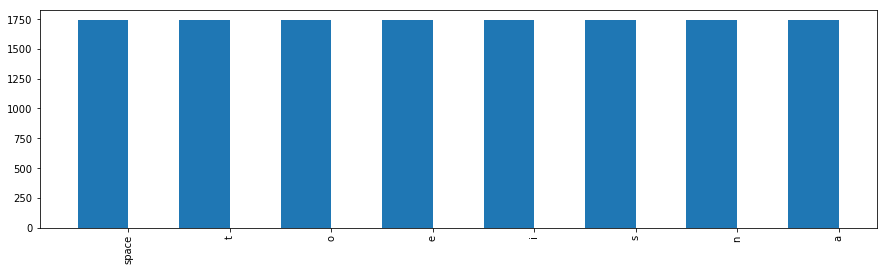

In [17]:
plot_key_hist(truncated_count.most_common())

### Shuffle data

In [18]:
df = df.sample(frac=1).reset_index(drop=True)

## Skip to Load If Normalized Data Already Exists on Disk

#### Normalize Data

In [19]:
type(df['data'][0])

numpy.ndarray

In [20]:
input_data = df['data'].values
input_data = np.stack(input_data, axis=0)

In [21]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
normalized_data = scaler.fit_transform(input_data)

C:\Users\stephen\AppData\Local\conda\conda\envs\tfgpu1.1\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### One Hot Encode Classes

In [22]:
n_classes = len(set(df['key']))

In [23]:
labels_str = [str(key) for key in df['key']]
lb = preprocessing.LabelBinarizer() # Create encoder
lb.fit(list(set(labels_str)))
labels = lb.transform(labels_str)

In [24]:
lb.classes_

array(['a', 'e', 'i', 'n', 'o', 's', 'space', 't'],
      dtype='<U5')

#### Split Training and Validation Data

Reshape to add 1 channel

In [25]:
normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))
# labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
normalized_data.shape

(13896, 10240, 1)

In [26]:
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(
    normalized_data, 
    labels, 
    test_size=0.1, 
    random_state=42)

# Define Network

### Input

In [27]:
def model_inputs(data_width, n_classes):
    """
    Create the model inputs
    :param data_width: The total number of samples in the recorded data point
    :param n_classes: Number of Classes
    :return: Tuple of (tensor of input audio data, key press labels, learning rate, keep_prob)
    """
    # TODO: Add audio channels to input
    
    with tf.name_scope("Inputs"):
        audio_inputs = tf.placeholder(tf.float32, [None, data_width, 1], name='inputs')
    with tf.name_scope("Targets"):
        key_labels = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_probability')

    return audio_inputs, key_labels, learning_rate, keep_prob

### Get Batches

In [28]:
def get_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

### Network

In [80]:
def network(X, keep_prob, n_classes):
    """
    Create the network
    :param X: Tensor of input recording(s)
    :param keep_prob: Tensor for the keep probability
    :param n_classes: Number of Classes
    :return: Tuple of (tensor output of the classifier, tensor logits of the classifier)
    """    
    # Hyperparameters
    alpha = 0.2
    h_dim = 32
    
    #print("X: {}".format(X.shape))
     
    with tf.name_scope("Hidden_Layer1"):
        #h1 = tf.layers.dense(X, h_dim, activation=None)
        h1 = tf.layers.conv1d(X, h_dim, 100, 10, 'same', activation=None)
        h1 = tf.layers.max_pooling1d(h1, 5, 2, 'same')
        h1 = tf.nn.dropout(h1, keep_prob) # Regularization
        h1 = tf.maximum(h1*alpha, h1) # Leaky ReLu
        h1 = tf.layers.batch_normalization(h1)
        
    #print("h1: {}".format(h1.shape))

    with tf.name_scope("Hidden_Layer2"):
        #h2 = tf.layers.dense(h1, h_dim, activation=None)
        h2 = tf.layers.conv1d(h1, h_dim*2, 50, 5, 'same', activation=None)
        #h2 = tf.layers.maxpool2d(h2, 5, 2, 'same')
        h2 = tf.nn.dropout(h2, keep_prob) # Regularization        
        h2 = tf.maximum(h2*alpha, h2) # Leaky ReLu
        h2 = tf.layers.batch_normalization(h2)
        
    #print("h2: {}".format(h2.shape))

    with tf.name_scope("Hidden_Layer3"):
        #h3 = tf.layers.dense(h2, h_dim, activation=None)
        h3 = tf.layers.conv1d(h2, h_dim*3, 25, 2, 'same', activation=None)
        #h3 = tf.layers.maxpool2d(h3, 3, 2, 'same')
        h3 = tf.nn.dropout(h3, keep_prob) # Regularization
        h3 = tf.maximum(h3*alpha, h3) # Leaky ReLu
        h3 = tf.layers.batch_normalization(h3)
        
    with tf.name_scope("Hidden_Layer4"):
        h4 = tf.layers.conv1d(h3, h_dim*4, 10, 1, 'same', activation=None)
        h4 = tf.nn.dropout(h4, keep_prob) # Regularization
        h4 = tf.maximum(h4*alpha, h4) # Leaky ReLu
        h4 = tf.layers.batch_normalization(h4)
    
    
    
    with tf.name_scope("Output"):
        flat_dim = int(h4.get_shape()[1])*int(h4.get_shape()[2])
        flat = tf.reshape(h4, [-1, flat_dim])
        #print("flat: {}".format(flat.shape))
        logits = tf.layers.dense(flat, n_classes, activation=None, name='logits')
        #print("logits: {}".format(logits.shape))
        #out = tf.nn.softmax(logits, name='softmax_out')

    return logits

### Show Stats

In [81]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    with tf.name_scope("Validation_Stats"):
        validation_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
        validation_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
        train_accuracy = session.run(accuracy, feed_dict={x: train_features[:1000], y: train_labels[:1000], keep_prob: 1.0})
        print("Train Accuracy: {}, Validation Accuracy: {}, Validation Loss: {}".format(train_accuracy, validation_accuracy, validation_loss))

### Build Neural Network

In [82]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x, y, learn_rate, keep_prob = model_inputs(data_width, n_classes)

#Model
logits = network(x, keep_prob, n_classes)

with tf.name_scope("Cost"):
    # Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss'), name='cost')
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learn_rate, name='optimizer').minimize(cost)

with tf.name_scope("Accuracy"):
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name='prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Write out the graph for TensorBoard

In [83]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/2', sess.graph)

### Hyperparameters

In [84]:
epochs = 5000
batch_size = 16
keep_probability = 0.70
learning_rate = 0.0001

# Train Neural Network

In [85]:
# Accuracy to beat (Min of 3 classes)
print("{:.3}%".format((1/n_classes)*100))

12.5%


In [86]:
save_model_path = './key_classification'

print('Training...')
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_features, batch_labels in get_batches(train_features, train_labels, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, 
                                           y: batch_labels, 
                                           learn_rate: learning_rate, 
                                           keep_prob: keep_probability})
        if epoch % 1 == 0:
            print('Epoch {}: '.format(epoch), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)         
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch 0: Train Accuracy: 0.13199999928474426, Validation Accuracy: 0.1258992850780487, Validation Loss: 2.073786973953247
Epoch 1: Train Accuracy: 0.27400001883506775, Validation Accuracy: 0.2755395770072937, Validation Loss: 1.568467617034912
Epoch 2: Train Accuracy: 0.30800002813339233, Validation Accuracy: 0.3050360083580017, Validation Loss: 1.4813799858093262
Epoch 3: Train Accuracy: 0.4399999976158142, Validation Accuracy: 0.4374100863933563, Validation Loss: 0.9968374967575073
Epoch 4: Train Accuracy: 0.4710000157356262, Validation Accuracy: 0.4705035984516144, Validation Loss: 0.7620723247528076
Epoch 5: Train Accuracy: 0.5049999356269836, Validation Accuracy: 0.5151079297065735, Validation Loss: 0.7107069492340088
Epoch 6: Train Accuracy: 0.5379999876022339, Validation Accuracy: 0.5244604349136353, Validation Loss: 0.6349624395370483
Epoch 7: Train Accuracy: 0.5359999537467957, Validation Accuracy: 0.533812940120697, Validation Loss: 0.5715106129646301
Epoch 8: Tra

Epoch 67: Train Accuracy: 0.8820000290870667, Validation Accuracy: 0.7669064998626709, Validation Loss: 0.048953283578157425
Epoch 68: Train Accuracy: 0.9049999713897705, Validation Accuracy: 0.7755395174026489, Validation Loss: 0.0366734080016613
Epoch 69: Train Accuracy: 0.893000066280365, Validation Accuracy: 0.7597122192382812, Validation Loss: 0.0528397299349308
Epoch 70: Train Accuracy: 0.9070000648498535, Validation Accuracy: 0.7769784331321716, Validation Loss: 0.044560112059116364
Epoch 71: Train Accuracy: 0.8970000743865967, Validation Accuracy: 0.7669064998626709, Validation Loss: 0.0359061174094677
Epoch 72: Train Accuracy: 0.8959999680519104, Validation Accuracy: 0.764748215675354, Validation Loss: 0.016153384000062943
Epoch 73: Train Accuracy: 0.8959999680519104, Validation Accuracy: 0.770503580570221, Validation Loss: 0.021857034415006638
Epoch 74: Train Accuracy: 0.9040000438690186, Validation Accuracy: 0.7726618051528931, Validation Loss: 0.04115051031112671
Epoch 75: 

Epoch 133: Train Accuracy: 0.9620000720024109, Validation Accuracy: 0.7913669347763062, Validation Loss: 0.003483843756839633
Epoch 134: Train Accuracy: 0.9670000076293945, Validation Accuracy: 0.7964028716087341, Validation Loss: 0.001979847438633442
Epoch 135: Train Accuracy: 0.9660000205039978, Validation Accuracy: 0.7906475067138672, Validation Loss: 0.0011053240159526467
Epoch 136: Train Accuracy: 0.9800000786781311, Validation Accuracy: 0.798561155796051, Validation Loss: 0.0023178430274128914
Epoch 137: Train Accuracy: 0.9709999561309814, Validation Accuracy: 0.7956833839416504, Validation Loss: 0.0024570815730839968
Epoch 138: Train Accuracy: 0.9790000319480896, Validation Accuracy: 0.7964028716087341, Validation Loss: 0.002053885255008936
Epoch 139: Train Accuracy: 0.9800000190734863, Validation Accuracy: 0.7978417277336121, Validation Loss: 0.00297602079808712
Epoch 140: Train Accuracy: 0.9790000319480896, Validation Accuracy: 0.798561155796051, Validation Loss: 0.00243711168

KeyboardInterrupt: 

### Test Model

In [ ]:
loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess: